In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow-addons

     |████████████████████████████████| 706kB 8.1MB/s 


In [ ]:
import os
import math
import pandas as pd
import collections
import cv2
import numpy as np
import cv2                 
from random import shuffle
from tqdm import tqdm  
import tensorflow as tf 
from tensorflow.keras import Model, models, layers
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
from collections import Counter
from skimage import data, io, img_as_ubyte
from skimage.filters import threshold_multiotsu

In [ ]:
#Pipeline automatic segmentation

In [ ]:
root_path = "/content/drive/MyDrive/TrainModels/Diabetes"

In [ ]:
database_path = os.path.join(os.path.join(root_path,'ThermoDataBase'),"Plantar Thermogram Database.xlsx")

In [ ]:
df_diabetes = pd.read_excel(database_path,index_col=None, header=None)

In [ ]:
df_diabetes = pd.read_excel(database_path, header=[0, 1], index_col=[0], sheet_name='Control Group')
df_DM = pd.read_excel(database_path, header=[0, 1], index_col=[0], sheet_name='DM Group')

In [ ]:
df_diabetes.head(10) #Temperatura promedio

Subject             Gender        Age (years)  ... LEFT FOOT      
        Unnamed: 1_level_1 Unnamed: 2_level_1  ...     TCI.2 TCI.3
CG001                    M               25.0  ...       LCA  26.1
CG002                    M               26.0  ...       LPA  25.7
CG003                    M               24.0  ...       MCA  26.4
CG004                    F               22.0  ...       MPA  25.8
CG005                    F               38.0  ...       NaN   NaN
CG006                    F               52.0  ...       NaN   NaN
CG007                    F               25.0  ...       NaN   NaN
CG008                    F               30.0  ...       NaN   NaN
CG009                    M               30.0  ...       NaN   NaN
CG010                    M               26.0  ...       NaN   NaN

[10 rows x 20 columns]

(-0.5, 55.5, 147.5, -0.5)

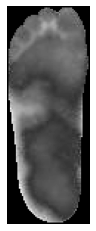

In [ ]:
image = cv2.imread(os.path.join(root_path,'DM001_M_R.png'))
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image_gray, cmap="gray")
plt.axis('off')

In [ ]:
image_gray.shape

(148, 56)

In [ ]:
def generateAngiosoms(image):
  image_angiosoms = image
  image_copy = np.copy(image)
  angiosoms = []

  #Superior Angiosoms
  initial_step_height = 0
  initial_step_width = 0

  final_step_height = 0
  initial_step_width = 0

  color = (255, 0, 0) 
  
  thickness = 2

  steps_height = round(image_gray.shape[0]/2.5)
  steps_width = round(image_gray.shape[1]/3)

  for i in range(3):
    step = i +1 
    initial_step_width = i * steps_width
    mask = np.zeros(image.shape)
      
    mask[0:steps_height, initial_step_width:steps_width*step] = image[0:steps_height, initial_step_width:steps_width*step]
    start_point = (i * steps_width,0)
    end_point = (steps_width*step, steps_height)
    image_angiosoms = cv2.rectangle(image_copy, start_point, end_point, color, thickness)
    angiosoms.append(mask)

  #Inferior Angiosoms

  steps_width = round(image_gray.shape[1]/2)

  for i in range(2):
    step = i +1 
    initial_step_width = i * steps_width
    mask = np.zeros(image.shape)
      
    mask[steps_height:image.shape[0], initial_step_width:steps_width*step] = image[steps_height:image.shape[0], initial_step_width:steps_width*step]

    start_point = (initial_step_width,steps_height)
    end_point = (steps_width*step, image.shape[0])
   
    image_angiosoms = cv2.rectangle(image_copy, start_point, end_point, color, thickness)
 
    angiosoms.append(mask)
  angiosoms.append(image_angiosoms)
  return angiosoms

In [ ]:
angiosoms = generateAngiosoms(image_gray)

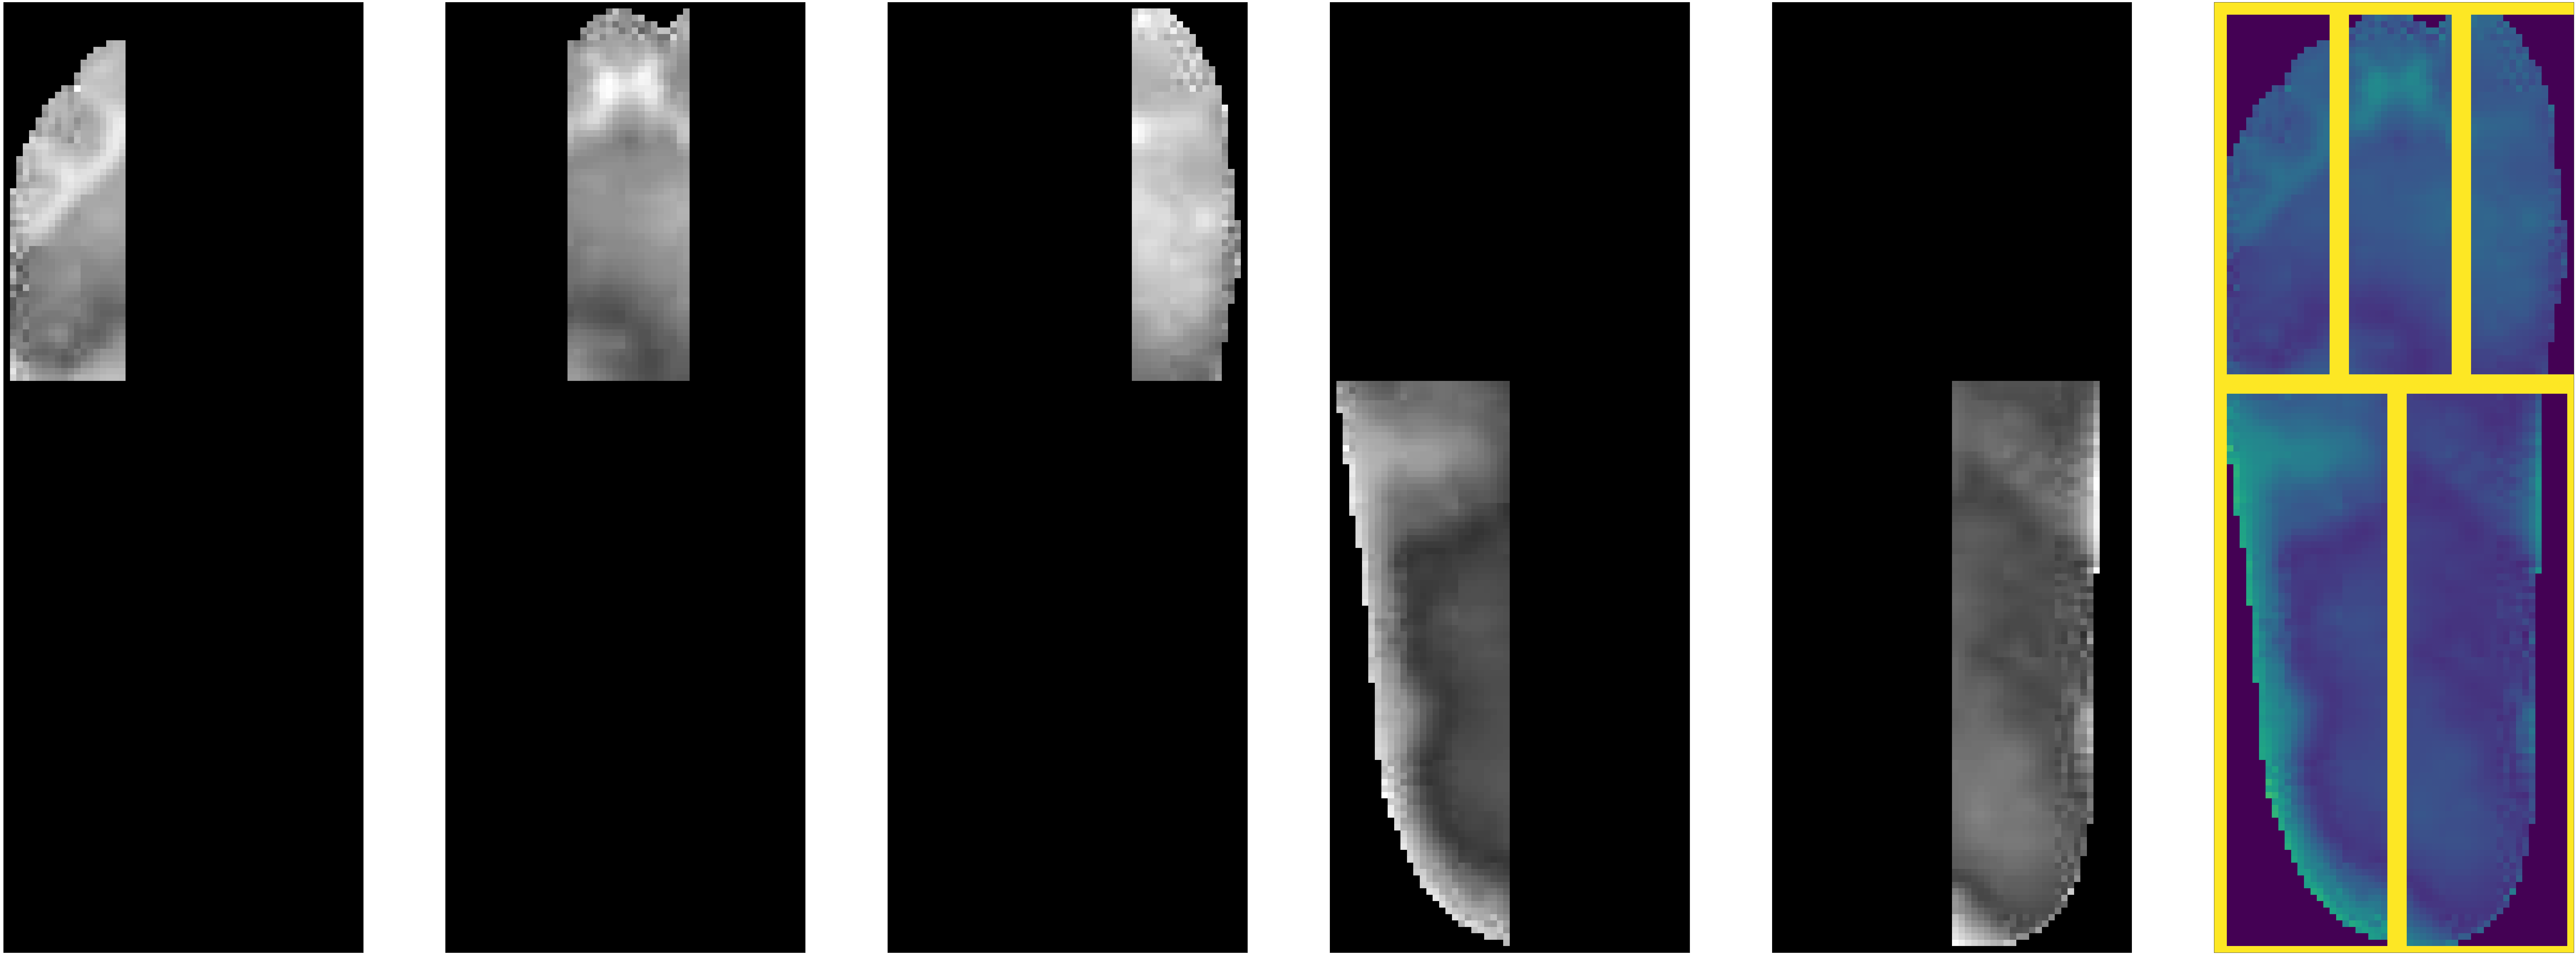

In [ ]:
fig=plt.figure(figsize=image_gray.shape)

for i,image in enumerate(angiosoms):
   
    sp=fig.add_subplot(1,6,i+1,xticks=[],yticks=[])

    if i==5:
      sp.imshow(image)
    else:
      sp.imshow(image,cmap="gray")        

In [ ]:
#.shape

In [ ]:
thresholds = threshold_multiotsu(image, classes=5)

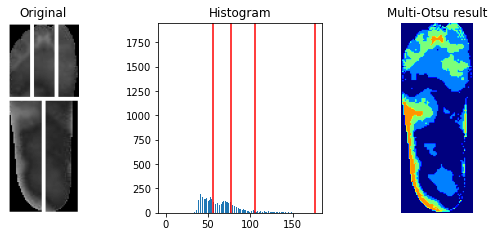

In [ ]:
# Using multi-Otsu for segmentation.

regions = np.digitize(image_gray, bins=thresholds)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))


ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from

ax[1].hist(image_gray.ravel(), bins=255)
ax[1].set_title('Histogram')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

# Plotting the Multi Otsu result.
ax[2].imshow(regions, cmap='jet')
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')

plt.subplots_adjust()

plt.show()

In [ ]:
thresholds

array([ 56,  77, 106, 176])

(0.0, 300.0)

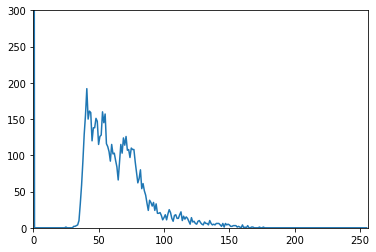

In [ ]:
#Histogram image

histogram,bins = np.histogram(image_gray.ravel(),256,[0,256])
plt.plot(histogram)
plt.xlim([0,256])
plt.ylim([0,300])

In [ ]:
# Shanon Entropy

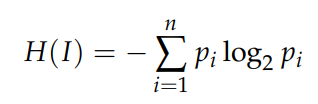

In [ ]:
def estimate_shannon_entropy(histogram):
    m = len(histogram)
    # Count ocurrency of each gray level
    bases = collections.Counter([tmp_base for tmp_base in histogram])
 
    shannon_entropy_value = 0
    for base in bases:
 
        n_i = bases[base]    
        p_i = n_i / float(m)
        entropy_i = p_i * (math.log(p_i, 2))
        shannon_entropy_value += entropy_i
 
    return shannon_entropy_value * -1

In [ ]:
estimate_shannon_entropy(histogram)

4.050527315108287

In [ ]:
#Fuzzy Sets

## DFTNet

In [ ]:
def DFTNet():
  model_net = models.Sequential()
  model_net.add(layers.Conv2D(32, kernel_size = (7, 7),  strides=(1, 1), input_shape=(199,88, 3)))
  model_net.add(layers.BatchNormalization())
  model_net.add(layers.Activation('relu'))

  model_net.add(layers.MaxPooling2D(pool_size=(3, 3),strides=(2, 2)))
  model_net.add(layers.Conv2D(64, kernel_size = (1, 1),  strides=(1, 1), padding="same"))
  model_net.add(layers.Conv2D(64, kernel_size = (3, 3),  strides=(1, 1), padding="same"))
  model_net.add(layers.BatchNormalization())
  model_net.add(layers.Activation('relu'))

  model_net.add(layers.MaxPooling2D(pool_size=(3, 3),strides=(2, 2)))
  model_net.add(layers.Conv2D(32, kernel_size = (3, 3),  strides=(1, 1), padding="same"))
  model_net.add(layers.BatchNormalization())
  model_net.add(layers.Activation('relu'))

  model_net.add(layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))
  model_net.add(layers.Conv2D(32, kernel_size = (3, 3),  strides=(1, 1), padding="same"))
  model_net.add(layers.BatchNormalization())
  model_net.add(layers.Activation('relu'))

  model_net.add(layers.Flatten())
  model_net.add(layers.Dense(2, name="predictions_head", activation='softmax'))
  return model_net

### Deep learning (Data set)
- El excel tiene 46 datos del grupo de control.
- pero en imágenes son: 45 CG (grupo de control), 122 DM (diabetes mellitus).

In [ ]:
rotation=False
augme_fourier=False

In [ ]:
def plot_feet(data_1, data_2, data_3, inx=-1):
  if inx==-1:
    inx=np.random.choice(np.shape(data_1)[0])
  plt.figure(figsize=(16,16))
  plt.subplot(1,6,1)
  plt.imshow(data_1[inx,5,...])
  plt.axis('off')
  plt.subplot(1,6,2)
  plt.imshow(data_1[inx,0,...])
  plt.axis('off')
  plt.subplot(1,6,3)
  plt.imshow(data_2[inx,5,...])
  plt.axis('off')
  plt.subplot(1,6,4)
  plt.imshow(data_2[inx,0,...])
  plt.axis('off')
  plt.subplot(1,6,5)
  plt.imshow(data_3[inx,5,...])
  plt.axis('off')
  plt.subplot(1,6,6)
  plt.imshow(data_3[inx,0,...])
  plt.axis('off')
  return inx

In [ ]:
def get_data_train(images, labels):
  x_images=np.concatenate((images[:,0,:,:],images[:,5,:,:])).astype('float32')
  x_images=x_images/np.max(x_images)
  y_labels=np.concatenate((labels, labels))
  return x_images, y_labels

In [ ]:
def split_data(xdat, ylab, rd=[]):
  n_sub=np.shape(xdat)[0]
  if len(rd)==0:
    rd=np.random.choice(n_sub,n_sub,replace=False)
  sp= int(n_sub*0.8)
  sp2=int(n_sub*0.9)

  train, valid, test=xdat[rd][:sp], xdat[rd][sp:sp2], xdat[rd][sp2:]
  ytr, yva, yt=ylab[rd][:sp], ylab[rd][sp:sp2], ylab[rd][sp2:]
  #print(np.shape(train), np.shape(valid), np.shape(test))

  return [train, valid, test], [ytr, yva, yt], rd

In [ ]:
def get_xy(images,fourier, labels, augmentation=False, Just_train=True):
  x_data, y_data=get_data_train(images, labels)
  x_data=x_data.reshape((np.shape(x_data)[0], np.shape(x_data)[1], np.shape(x_data)[2], 1))
  x_data=np.array(tf.image.grayscale_to_rgb(tf.constant(x_data)))
  x_d, y_d, rand=split_data(x_data, y_data)
  
  if augmentation:
    x_data2, y_data2=get_data_train(fourier, labels)
    x_data2=x_data2.reshape((np.shape(x_data2)[0], np.shape(x_data2)[1], np.shape(x_data2)[2], 1))
    x_data2=np.array(tf.image.grayscale_to_rgb(tf.constant(x_data2)))
    x_d2, y_d2, _=split_data(x_data2, y_data2, rand)
    if Just_train:
      lim=1
    else:
      lim=3
    for i in range(lim):
      x_d[i]=np.concatenate((x_d[i],x_d2[i]))
      y_d[i]=np.concatenate((y_d[i],y_d2[i]))
  return x_d, y_d

In [ ]:
from numpy.fft import fft2, fftshift, ifft2
import glob
import scipy.io as sio

In [ ]:
roi=['L', 'L_LCA',	'L_LPA',	'L_MCA',	'L_MPA', 'R', 'R_LCA',	'R_LPA',	'R_MCA',	'R_MPA']
data=sio.loadmat(root_path+'/data.mat')
augm=sio.loadmat('/content/drive/MyDrive/TrainModels/augmented.mat')['datas']
imargb=data['RGB']
imagra=data['Gray']
index =data['index']
type_p=data['type'][0]
gender=data['gender'][0]
siz=np.shape(imargb)

046 (167, 10, 200, 88, 3) 
Group Control (0) or Diabetes Mellitus (1):  1 
Gender Male (0) or Female (1): 0


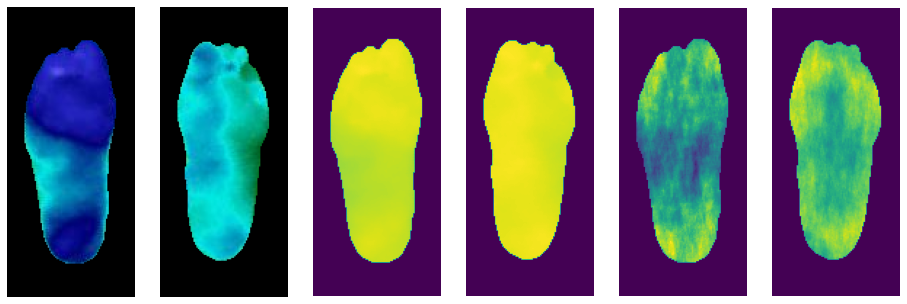

In [ ]:
inx=plot_feet(imargb, imagra, augm)
print(index[inx], siz,'\nGroup Control (0) or Diabetes Mellitus (1): ', type_p[inx], '\nGender Male (0) or Female (1):', gender[inx])

In [ ]:
split_x, split_y=get_xy(imagra, augm, type_p, augme_fourier)

In [ ]:
x_train, y_train=split_x[0], split_y[0] 
x_valid, y_valid=split_x[1], split_y[1] 
x_test,  y_test =split_x[2], split_y[2] 

In [ ]:
if rotation:
  x_train=np.concatenate((x_train, np.flip(x_train, axis=1), np.flip(x_train, axis=2), np.flip(np.flip(x_train, axis=1), axis=2)))
  y_train=np.concatenate((y_train, y_train, y_train, y_train))

### Networks

In [ ]:
def fourier_fase(image_F):
  image_F=fft2(image_F)
  Mod=np.abs(image_F)
  Mod=Mod*np.random.rand(np.shape(Mod)[0], np.shape(Mod)[1])
  fas=np.arctan(image_F.imag/image_F.real)
  pi_n=-np.logical_and(image_F.imag<0,image_F.real<0).astype('int')*np.pi
  pi_p=np.logical_and(image_F.imag>0,image_F.real<0).astype('int')*np.pi
  fas=fas+pi_n+pi_p
  image_F=(Mod*np.cos(fas)+Mod*np.sin(fas)*1j)
  inv=ifft2(image_F)
  nor=np.abs(inv).astype('float64')
  nor=(nor-np.min(nor))/(np.max(nor)-np.min(nor))
  return nor

In [ ]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras.backend as K

In [ ]:
def one_hot(vec):
  vec = vec
  shape = (vec.size, 2)
  one = np.zeros(shape)
  rows = np.arange(vec.size)
  one[rows, vec.astype('int')] = 1
  return one

In [ ]:
def resnet50v2():
  model_net=Sequential()
  model_net.add(ResNet50V2(include_top=False, input_shape=(199,88,3), pooling='avg', classes=2))
  model_net.add(Dense(2, activation='softmax'))
  return model_net

In [ ]:
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

In [ ]:
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

### Unsupervised

In [ ]:
minimo=np.min(imagra[imagra!=0])
maximo=np.max(imagra)

In [ ]:
GC_images=np.concatenate((imagra[type_p==0][:,0,:,:], imagra[type_p==0][:,5,:,:]))
GC_images=np.concatenate((GC_images, np.flip(GC_images, axis=1), np.flip(GC_images, axis=2), np.flip(np.flip(GC_images, axis=1), axis=2))).astype('float32')
GC_images=((GC_images-minimo)/(maximo-minimo))
GC_images[GC_images<0]=0
GC_images=GC_images**1.3
GC_images=GC_images.reshape((np.shape(GC_images)[0], np.shape(GC_images)[1], np.shape(GC_images)[2], 1))
GC_images=np.array(tf.image.resize(tf.image.grayscale_to_rgb(tf.constant(GC_images)), (224, 224)))

In [ ]:
!pip install segmentation-models

In [ ]:
%env SM_FRAMEWORK=tf.keras

In [ ]:
from segmentation_models import Unet, Linknet, FPN, PSPNet

In [ ]:
efficient=Unet('efficientnetb7', input_shape=(224,224,3))
efficient.compile(optimizer='Adadelta', loss='mse', metrics=['acc', 'mse'])

In [ ]:
es2 = EarlyStopping(patience=10, min_delta=0.00001, restore_best_weights=True)
mcp2 = ModelCheckpoint(filepath='/content/drive/MyDrive/nosupervisado.hdf5', save_best_only=True, save_weights_only=True)

In [ ]:
efficient.fit(GC_images, GC_images, 16, 1000, validation_split=0.1)#, callbacks=[es2, mcp2])

In [ ]:
DM_images=np.concatenate((imagra[type_p==1][:,0,:,:], imagra[type_p==1][:,5,:,:]))
DM_images=((DM_images-minimo)/(maximo-minimo))
DM_images[DM_images<0]=0
DM_images=DM_images**1.3
DM_images=DM_images.reshape((np.shape(DM_images)[0], np.shape(DM_images)[1], np.shape(DM_images)[2], 1))
DM_images=np.array(tf.image.resize(tf.image.grayscale_to_rgb(tf.constant(DM_images)), (224, 224)))

In [ ]:
result=efficient.predict(GC_images)

In [ ]:
r_ind=np.random.choice(np.shape(result)[0])
plt.figure(figsize=(13,5))
plt.subplot(1,3,1)
plt.imshow(GC_images[r_ind,:,:,0]); plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(result[r_ind,:,:,0]); plt.axis('off')
plt.subplot(1,3,3)
plt.imshow((GC_images[r_ind,:,:,0]>0.02)*np.sqrt((GC_images[r_ind,:,:,0]-result[r_ind,:,:,0])**2)); plt.axis('off')
print(np.mean(tf.keras.metrics.mse(GC_images[r_ind,:,:,0], result[r_ind,:,:,0])))'''

In [ ]:
ssx=np.shape(GC_images[:45])[0]
indices=[]
for i in range(ssx):
  indices.append(np.mean(tf.keras.metrics.mse(GC_images[i,:,:,0], result[i,:,:,0])))

In [ ]:
plt.plot(np.sort(GC_images[GC_images!=0]))'''

In [ ]:
result_dm=efficient.predict(DM_images)

In [ ]:
r_ind2=np.random.choice(np.shape(result_dm)[0])
plt.figure(figsize=(13,5))
plt.subplot(1,3,1)
plt.imshow(DM_images[r_ind2,:,:,0]); plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(result_dm[r_ind2,:,:,0]); plt.axis('off')
plt.subplot(1,3,3)
plt.imshow((DM_images[r_ind2,:,:,0]>0.02)*np.sqrt((DM_images[r_ind2,:,:,0]-result_dm[r_ind2,:,:,0])**2)); plt.axis('off')
print(np.mean(tf.keras.metrics.mse(DM_images[r_ind2,:,:,0], result_dm[r_ind2,:,:,0])))

In [ ]:
ssx2=np.shape(DM_images)[0]
indices2=[]
for i in range(ssx2):
  indices2.append(np.mean(tf.keras.metrics.mse(DM_images[i,:,:,0], result_dm[i,:,:,0])))

In [ ]:
plt.plot(indices,  'or')
plt.plot(indices2, '.b')

### Transformer

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [ ]:
num_classes = 2
input_shape = (199,88, 3)

image_size_r = 200  # Tamaño a reescalar la imagen
image_size_c = 88  # Tamaño a reescalar la imagen
patch_size = [10, 11]  # Tamaño de los parches a extaer
num_patches = (image_size_r// patch_size[0])*(image_size_c // patch_size[1]) #Número de parches por imagen
projection_dim = 64
num_heads = 4
transformer_units = [projection_dim * 2, projection_dim,]  # tamaño de las capas del tranformer
transformer_layers = 8
mlp_head_units = [2048, 1024]  # tamaño de la capas densas del clasificador final

In [ ]:
#Aumento de datos (Capa de secuencia)
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.Resizing(image_size_r, image_size_c),
        #layers.experimental.preprocessing.RandomFlip("horizontal"),
        #layers.experimental.preprocessing.RandomRotation(factor=0.02),
        #layers.experimental.preprocessing.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Calcula media y la varianza de los datos de entrenamiento por la normalización.
data_augmentation.layers[0].adapt(x_train)

In [ ]:
#Función del perceptrón multicapa
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size[0], self.patch_size[1], 1],
            strides=[1, self.patch_size[0], self.patch_size[1], 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 200 X 88
Patch size: 10 X 11
Patches per image: 160
Elements per patch: 330


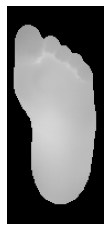

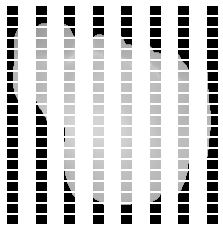

In [ ]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("float32"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size_r, image_size_c)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size_r} X {image_size_c}")
print(f"Patch size: {patch_size[0]} X {patch_size[1]}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(20, 8, i + 1)
    patch_img = tf.reshape(patch, (patch_size[0], patch_size[1], 3))
    plt.imshow(patch_img.numpy().astype("float32"))
    plt.axis("off")

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
#Crear el clasificador con bloques con tranformers
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Aumento de datos (tambien se reescala la image y normaliza)
    augmented = data_augmentation(inputs)
    # Crea los parches
    patches = Patches(patch_size)(augmented)
    # codifica los parches y le asigna una posicion
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

### Entrenamiento

In [ ]:
def get_model(network, opt, loss_name):
  try:
    del model
  except:
    print('done')
  
  if network=='resnet50v2':
    model=resnet50v2()
  
  if network=='DFTNet':
    model=DFTNet()

  if network=='Transformer_x':
    model=create_vit_classifier()

  model.compile(optimizer='Adadelta',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=tf.keras.metrics.SparseCategoricalAccuracy(name="acc"))
  return model

In [ ]:
y_train=y_train.reshape((len(y_train),1)).astype('int64')
y_valid=y_valid.reshape((len(y_valid),1)).astype('int64')
y_test=y_test.reshape((len(y_test),1)).astype('int64')

print(np.shape(x_train), np.shape(y_train))
print(np.shape(x_valid), np.shape(y_valid))
print(np.shape(x_test), np.shape(y_test))

(267, 199, 88, 3) (267, 1)
(33, 199, 88, 3) (33, 1)
(34, 199, 88, 3) (34, 1)


### Training

In [ ]:
import time
from IPython.display import clear_output

In [ ]:
path_save=root_path[:-8]
path_w=path_save+'weights/'
df = pd.DataFrame(columns=('run_n', 'network', 'optimizer', 'loss', 'epochs', 'total_parameters', 'time','augm', 'acc','sensitivity','specificity','FPR', 'result_mat'))
df.head()

,run_n,network,optimizer,loss,epochs,total_parameters,time,augm,acc,sensitivity,specificity,FPR,result_mat


In [ ]:
for network in ['Transformer_x']:
  epochs=200
  optimizer='Adadelta'
  loss='categorical_crossentropy'
  augmentation='_'.join(['rot', str(rotation), 'fourier', str(augme_fourier)])
  batch_size=16

  name_csv='_'.join(['Thermography',network,optimizer])

  if not os.path.exists(path_save+name_csv+'.csv'):
    df.to_csv(path_save+name_csv+'.csv')

  for run in range(8):
    control=True
    tic = time.time()
    name='_'.join([name_csv,loss,augmentation,'run',str(run)])
    print(network,name)

    model=get_model(network,optimizer,loss)
    ES = EarlyStopping(patience=10, min_delta=0.00001, restore_best_weights=True)
    MCP = ModelCheckpoint(filepath=path_w+name+'.hdf5', save_best_only=True, save_weights_only=True)

    try:
      results=model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=epochs, batch_size=batch_size, callbacks=[ES, MCP])
      model.save_weights(path_w+name+"w.h5")
      toc=time.time()-tic
    except:
      print('Training error')
      control=False
    
    if control:
      sio.savemat(path_w+name+'.mat', results.history)

      #Validation    
      y_hat=model.predict(x_test)
      acc=np.mean(np.argmax(y_hat, axis=1)==y_test[:,0])
      sensi=float(sensitivity(one_hot(y_test[:,0]), y_hat))
      speci=float(specificity(one_hot(y_test[:,0]), y_hat))
      total_p=model.count_params()
      
      #data frame
      df2=pd.read_csv(path_save+name_csv+'.csv')
      df2=df2.append({'run_n': run,
                    'network': network,
                    'optimizer': optimizer,
                    'loss': loss,
                    'epochs': epochs,
                    'total_parameters': total_p,
                    'time': toc,
                    'augm': augmentation,
                    'acc': acc,
                    'sensitivity': sensi,
                    'specificity': speci,
                    'FPR': 1-speci,
                    'result_mat': path_w+name+'.mat'} , ignore_index=True)
      
      df2.drop(df2.columns[:np.where(df2.columns=='run_n')[0][0]], axis=1) 
      df2.to_csv(path_save+name_csv+'.csv')
      clear_output(wait=True)

Transformer_x Thermography_Transformer_x_Adadelta_categorical_crossentropy_rot_False_fourier_False_run_0
done
Epoch 1/200
17/17 [==============================] - 17s 208ms/step - loss: 1.5133 - acc: 0.5408 - val_loss: 0.6542 - val_acc: 0.7576
Epoch 2/200
17/17 [==============================] - 2s 113ms/step - loss: 1.3113 - acc: 0.5993 - val_loss: 0.6658 - val_acc: 0.7576
Epoch 3/200
14/17 [=======================>......] - ETA: 0s - loss: 1.3129 - acc: 0.6350

### Preprocesamiento de las imágenes (se guardó todo en el .mat)

In [ ]:
No_ejecutar

In [ ]:
rec=[(194,85,3), (193,85), (194,85,3), (193,85), (194,85,3), (193,85), (194,85,3), (193,85), (194,85,3), (193,85), (200,88,3), (199,88), (200,88,3), (199,88), (200,88,3), (199,88), (200,88,3), (199,88), (200,88,3), (199,88)]
rec=[(200, 88, 3), (199, 88)]
subjects=glob.glob(root_path+'/*L.png')
print(np.shape(subjects))

In [ ]:
def fit_images(ima, sz):
  sh=np.shape(ima)
  sr=int((sz[0]/2)-(sh[0]/2))
  er=int(sr+sh[0])
  sc=int((sz[1]/2)-(sh[1]/2))
  ec=int(sc+sh[1])

  if len(sz)==3:
    base=np.zeros(sz, dtype=('uint8'))
    base[sr:er,sc:ec,:]=ima
  else:
    base=np.zeros(sz, dtype=('float64'))
    base[sr:er,sc:ec]=ima
  return base

In [ ]:
def get_information(strg):
  if strg[44:46]=='CG':
    type_p=0
  else:
    type_p=1
  ind=strg[46:49]
  if strg[50:51]=='M':
    gender=0
  else:
    gender=1
  pp=strg[:52]
  pc=pp.replace('Diabetes/','Diabetes/ThermoDataBase/')

  IMA=[]
  CSV=[]

  for ro in roi:
    ima=fit_images(cv2.imread(pp+ro+'.png'), rec[0])
    csv=fit_images(pd.read_csv(pc+ro+'.csv').values, rec[1])
    IMA.append(ima)
    CSV.append(csv)
    #print(np.shape(ima), np.shape(csv), end='|')
  #print('')
  return type_p, ind, gender, IMA, CSV

In [ ]:
ind_s=[]
clasp=[]
gende=[]
images=[]
images2=[]

for i in subjects:
  clas,ind,gen,imas,csvs=get_information(i)
  ind_s.append(ind)
  clasp.append(clas)
  gende.append(gen)
  images.append(imas)
  images2.append(csvs)

In [ ]:
sz=np.shape(imagra)
four_gra=np.zeros(sz)

for sub in range(sz[0]):
  for roi in range(sz[1]):
    four=[]
    for i in range(1000):
      four.append(fourier_fase(imagra[sub,roi]))    
    four_gra[sub,roi]=np.var(four, axis=0)*(imagra[sub,roi]>1)

In [ ]:
sz=np.shape(imagra)
four_gra2=np.zeros(sz)
for sub in range(sz[0]):
  for roi in range(sz[1]):
    four=fourier_fase(imagra[sub,roi])  
    four_gra2[sub,roi]=four*(imagra[sub,roi]>1)